In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, CuDNNLSTM, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/'
DATA = DIRECTORY + 'vehicle_data/' 

/
Mounted at /content/gdrive


In [3]:
df = pd.read_csv(DATA + 'records_all_unix_csv.csv')
df.head()

,record_id,timezone,created,modified,occurred_from,occurred_from_unix,occurred_from_hour,occurred_to,lat,lon,...,weather,light,Severity,driverIncidentDetails_id,Main cause,Description,Collision-type,Email of Encoder,Reporting Agency,Location Approximate
0,a913cced-1b3d-41ed-b5e6-52ba87816c49,UTC,2021-10-15 08:49:04,2021-10-15 08:49:04,2016-09-15 04:55:52,1473915352,4,2021-10-15 08:41:52,8.503039,124.642709,...,clear-day,dawn,Property Damage,7e5037c0-8383-434c-a40d-5ff2600df7f9,Human error,MC vs. PUJ,Side-swipe,rta.cdo@gmail.com,Other,Yes
1,cdf2e78c-a345-4ecb-9299-49aa93eacc1c,UTC,2021-10-15 08:38:18,2021-10-15 08:50:19,2016-12-11 03:32:50,1481427170,3,2021-10-15 08:32:50,8.496025,124.625377,...,clear-day,day,Injury,37c04e5d-238b-4cd1-bbdd-2b0ea88a38a6,Human error,NaN,Side-swipe,rta.cdo@gmail.com,Other,Yes
2,04660c01-6070-4e6e-850d-f2aeed151eb7,UTC,2019-01-01 12:55:33,2019-01-01 12:55:33,2019-01-01 07:01:36,1546326096,7,2019-01-01 07:01:36,14.599614,121.049595,...,partly-cloudy-day,day,Property Damage,d271e8b3-155a-41d6-9226-02c99e97e782,Human error,NaN,Side-swipe,NaN,MMDA Metrobase,NaN
3,b1bb4e9e-981f-4101-87f7-86ac494c3719,UTC,2019-01-01 13:01:52,2019-01-01 13:01:52,2019-01-01 07:06:27,1546326387,7,2019-01-01 07:06:27,14.536532,120.988870,...,partly-cloudy-day,day,Property Damage,5a9bafeb-bf22-4d29-910d-19c349353d9b,Human error,NaN,Side-swipe,NaN,MMDA Metrobase,NaN
4,d12db962-0464-4944-b376-f993d272ee2b,UTC,2019-01-01 13:03:27,2019-01-01 13:03:27,2019-01-01 08:23:46,1546331026,8,2019-01-01 08:23:46,14.631424,121.074142,...,partly-cloudy-day,day,Property Damage,3b7fcdf1-c853-4699-95d2-49936f56875d,Human error,NaN,Side-swipe,NaN,MMDA Metrobase,NaN


In [4]:
df = df[['weather', 'light', 'Main cause', 'Collision-type', 'Severity' ]]
# df = df[['lat', 'lon', 'weather', 'light', 'Main cause', 'Collision-type', 'occurred_from_unix', 'Severity' ]]
df = df.rename(columns={'Main cause': 'main_cause', 'Collision-type': 'collision_type', 'Severity' : 'severity'})
df = df.iloc[:-1]

In [5]:
df.shape

(11265, 5)

In [6]:
df = df.dropna()
df.reset_index(drop=True)
df.shape

(8798, 5)

In [7]:
df = df.iloc[:-1]
df

,weather,light,main_cause,collision_type,severity
0,clear-day,dawn,Human error,Side-swipe,Property Damage
1,clear-day,day,Human error,Side-swipe,Injury
2,partly-cloudy-day,day,Human error,Side-swipe,Property Damage
3,partly-cloudy-day,day,Human error,Side-swipe,Property Damage
4,partly-cloudy-day,day,Human error,Side-swipe,Property Damage
...,...,...,...,...,...
11059,clear-day,day,Human error,Side-swipe,Property Damage
11060,clear-day,day,Human error,Side-swipe,Property Damage
11061,clear-day,day,Human error,Side-swipe,Property Damage
11062,clear-day,day,Human error,Side-swipe,Property Damage


In [8]:
df.dtypes

weather           object
light             object
main_cause        object
collision_type    object
severity          object
dtype: object

In [9]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [10]:
X

array([['clear-day', 'dawn', 'Human error', 'Side-swipe'],
       ['clear-day', 'day', 'Human error', 'Side-swipe'],
       ['partly-cloudy-day', 'day', 'Human error', 'Side-swipe'],
       ...,
       ['clear-day', 'day', 'Human error', 'Side-swipe'],
       ['clear-day', 'day', 'Human error', 'Side-swipe'],
       ['clear-day', 'day', 'Human error', 'Side-swipe']], dtype=object)

In [11]:
y

array(['Property Damage', 'Injury', 'Property Damage', ...,
       'Property Damage', 'Property Damage', 'Property Damage'],
      dtype=object)

In [13]:
# df = pd.DataFrame(X, columns = ['lat', 'lon', 'weather', 'light', 'main_cause', 'collision_type', 'occurred_from'])
df = pd.DataFrame(X, columns = ['weather', 'light', 'main_cause', 'collision_type'])
df

,weather,light,main_cause,collision_type
0,clear-day,dawn,Human error,Side-swipe
1,clear-day,day,Human error,Side-swipe
2,partly-cloudy-day,day,Human error,Side-swipe
3,partly-cloudy-day,day,Human error,Side-swipe
4,partly-cloudy-day,day,Human error,Side-swipe
...,...,...,...,...
8792,clear-day,day,Human error,Side-swipe
8793,clear-day,day,Human error,Side-swipe
8794,clear-day,day,Human error,Side-swipe
8795,clear-day,day,Human error,Side-swipe


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['weather'])], remainder='passthrough')
X = np.array(ct.fit_transform(df))


In [ ]:
# assert 1 > 2

In [15]:
X.shape

(8797, 13)

In [16]:
X[0]

array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 'dawn',
       'Human error', 'Side-swipe'], dtype=object)

In [17]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [10])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [18]:
X.shape

(8797, 16)

In [19]:
X[0]

array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 'Human error', 'Side-swipe'], dtype=object)

In [20]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [14])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [21]:
X[0]

array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 'Side-swipe'], dtype=object)

In [22]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [18])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [23]:
X.shape

(8797, 30)

In [24]:
X[0]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,
       0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0], dtype=object)

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[5 3 5 ... 5 5 5]


In [26]:
print(set(y))

{0, 1, 2, 3, 4, 5}


In [27]:
total = X.shape[0]
total

8797

In [28]:
validation_len = (int) (total * 0.10)
validation_len

879

In [29]:
percent_len = total-validation_len
percent_len

7918

In [30]:
X_validation = X[percent_len:]
X_train_test = X[:percent_len]
y_validation = y[percent_len:]
y_train_test = y[:percent_len]

In [ ]:
assert 1 > 2

AssertionError: ignored

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size = 0.15, random_state = 0)

In [35]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [36]:
X_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
X_train.shape

(6730, 30)

In [38]:
X_train.shape[1:]

(30,)

In [39]:
y_train.shape

(6730,)

In [ ]:
y_train

In [54]:
ann = tf.keras.models.Sequential()
ann.add(LSTM (64,  input_shape=(X_train.shape[1],1), return_sequences=True)) 
ann.add(Dropout(0.5))

ann.add(LSTM (64, return_sequences=True)) 
ann.add(Dropout(0.5))

# ann.add(LSTM (50, return_sequences=True)) 
# ann.add(Dropout(0.2))

ann.add(LSTM (64)) 
ann.add(Dropout(0.5))

# remove this
# ann.add(Dense(32))
# ann.add(Dropout(0.2))
# ann.add(Activation('relu'))

ann.add(tf.keras.layers.Dense(units=6, activation='softmax'))



In [55]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.01)
ann.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# from tensorflow.keras.optimizers import SGD
# opt = SGD(lr=0.2)
# ann.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [56]:
history = ann.fit(X_train, y_train, batch_size=32, epochs = 10, validation_split=0.1, verbose=1)

Epoch 1/10
190/190 [==============================] - 72s 61ms/step - loss: 0.3986 - accuracy: 0.8968 - val_loss: 0.3380 - val_accuracy: 0.9004
Epoch 2/10
190/190 [==============================] - 10s 54ms/step - loss: 0.3669 - accuracy: 0.9013 - val_loss: 0.3387 - val_accuracy: 0.9004
Epoch 3/10
190/190 [==============================] - 10s 53ms/step - loss: 0.3641 - accuracy: 0.9013 - val_loss: 0.3421 - val_accuracy: 0.9004
Epoch 4/10
190/190 [==============================] - 10s 54ms/step - loss: 0.3623 - accuracy: 0.9013 - val_loss: 0.3442 - val_accuracy: 0.9004
Epoch 5/10
190/190 [==============================] - 10s 54ms/step - loss: 0.3629 - accuracy: 0.9013 - val_loss: 0.3394 - val_accuracy: 0.9004
Epoch 6/10
190/190 [==============================] - 11s 58ms/step - loss: 0.3609 - accuracy: 0.9013 - val_loss: 0.3394 - val_accuracy: 0.9004
Epoch 7/10
190/190 [==============================] - 10s 53ms/step - loss: 0.3578 - accuracy: 0.9013 - val_loss: 0.3389 - val_accuracy:

In [57]:
ann.evaluate(X_test,y_test, batch_size=8)

149/149 [==============================] - 1s 9ms/step - loss: 0.3500 - accuracy: 0.9015


[0.3500252068042755, 0.9015151262283325]

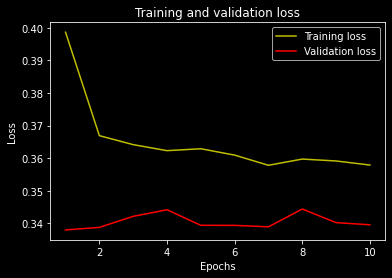

In [58]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

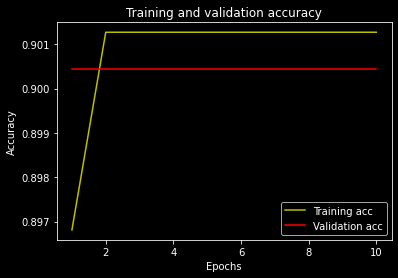

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
y_pred = ann.predict(X_test)
y_pred = np.amax(y_pred, axis=1)
y_pred

array([0.91059524, 0.91059494, 0.9105948 , ..., 0.91059494, 0.9105948 ,
       0.9105948 ], dtype=float32)

In [61]:
y_pred = ann.predict(X_test, batch_size=100)
y_pred1D = y_pred.argmax(1)
print ('Accuracy on test data: ' + str(accuracy_score(y_test, y_pred1D)))

Accuracy on test data: 0.9015151515151515


In [ ]:
assert 1 > 2

VALIDATION

In [62]:
X_validation_test = sc.transform(X_validation)

In [63]:
y_pred_validation = ann.predict(X_validation_test, batch_size=100)
y_pred_validation1D = y_pred_validation.argmax(1)
print ('Accuracy on validation data: ' + str(accuracy_score(y_validation, y_pred_validation1D)))

Accuracy on validation data: 0.8145620022753128
